In [38]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json

import sys
sys.path.append('../')
from helpers import cm2inch, title, show_num_contours, load_datasets
from melodic_contour import *
matplotlib.style.use('styles.mplstyle')

from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import tslearn
from tslearn.metrics import cdist_dtw

from scipy.spatial import distance_matrix
from scipy.spatial.distance import squareform
from unidip.dip import diptst as diptest

In [14]:
meta = pd.read_csv('../data/contours/contours-200-metadata.csv', index_col=0)

In [63]:
def load_data(representation, subset_size, metric):
    meta = pd.read_csv(f'../data/contours/contours-{subset_size}-metadata.csv', index_col=0)
    X = np.loadtxt(f'../data/mds/metric-mds-{metric}-{subset_size}-{representation}.txt.gz')
    sm = squareform(np.loadtxt(f'../data/similarities/sim-{metric}-{subset_size}-{representation}.txt.gz'))
    return sm, X, meta

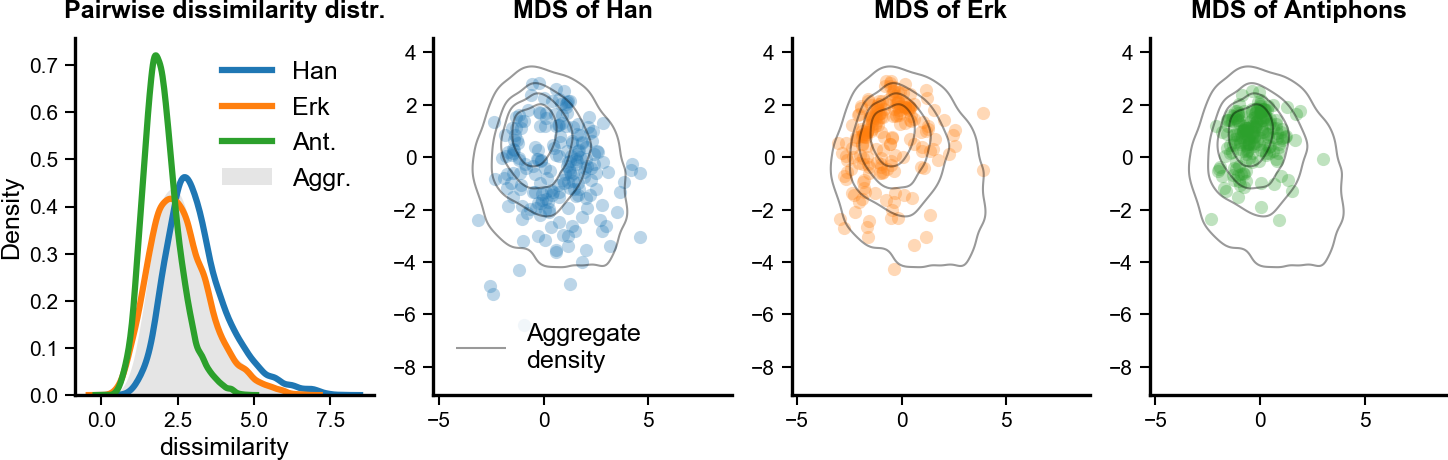

In [86]:
bw_adjust = 1
scatter_kwds = dict(s=10, alpha=.3, lw=0)

def show_mds(X, dataset_id, **kwargs):
    x, y = X.T
    idx = meta.dataset_id == dataset_id
    sns.kdeplot(x=x, y=y, levels=5, linewidths=.5, alpha=.4, 
                color='k', bw_adjust=bw_adjust, label='Aggregate\ndensity')
    plt.scatter(x[idx], y[idx], **scatter_kwds, **kwargs)
    plt.title('MDS of Han')

def show_space(sm, X, meta):
    
    erk_idx = meta.dataset_id == 'erk'
    han_idx = meta.dataset_id == 'han'
    ant_idx = meta.dataset_id == 'liber-antiphons'
    subset_idx = meta.dataset_id.isin(['erk', 'han', 'liber-antiphons'])
    erk_dist = squareform(sm[erk_idx,:][:, erk_idx])
    han_dist = squareform(sm[han_idx,:][:, han_idx])
    ant_dist = squareform(sm[ant_idx,:][:, ant_idx])
    subset_dist = squareform(sm[subset_idx,:][:, subset_idx])

    plt.figure(figsize=cm2inch(15, 4))

    plt.subplot(141)
    sns.kdeplot(han_dist, color="C0", label='Han', bw_adjust=bw_adjust)
    sns.kdeplot(erk_dist, color="C1", label='Erk', bw_adjust=bw_adjust)
    sns.kdeplot(ant_dist, color="C2", label='Ant.', bw_adjust=bw_adjust)
    sns.kdeplot(subset_dist, color="k", shade=True, alpha=0.1, lw=0, label='Aggr.', bw_adjust=bw_adjust)
    plt.title('Pairwise dissimilarity distr.')
    plt.xlabel('dissimilarity')
    plt.legend()

    plt.subplot(142)
    show_mds(X, 'han', color='C0')
    plt.title('MDS of Han')
    plt.legend()

    plt.subplot(143)
    show_mds(X, 'erk', color='C1')
    plt.title('MDS of Erk')

    plt.subplot(144)
    show_mds(X, 'liber-antiphons', color='C2')
    plt.title('MDS of Antiphons')

show_space(sm, X, meta)

## Euclidean


- Normalization does clearly change something: it removes some of the differences?
- Smoothing doesn't change much
- Intervals and derivatives look very much identical
- Smooth derivatives decrease the overall distance a lot and increase variance a little, but no changes in the relative shapes of dist-dists

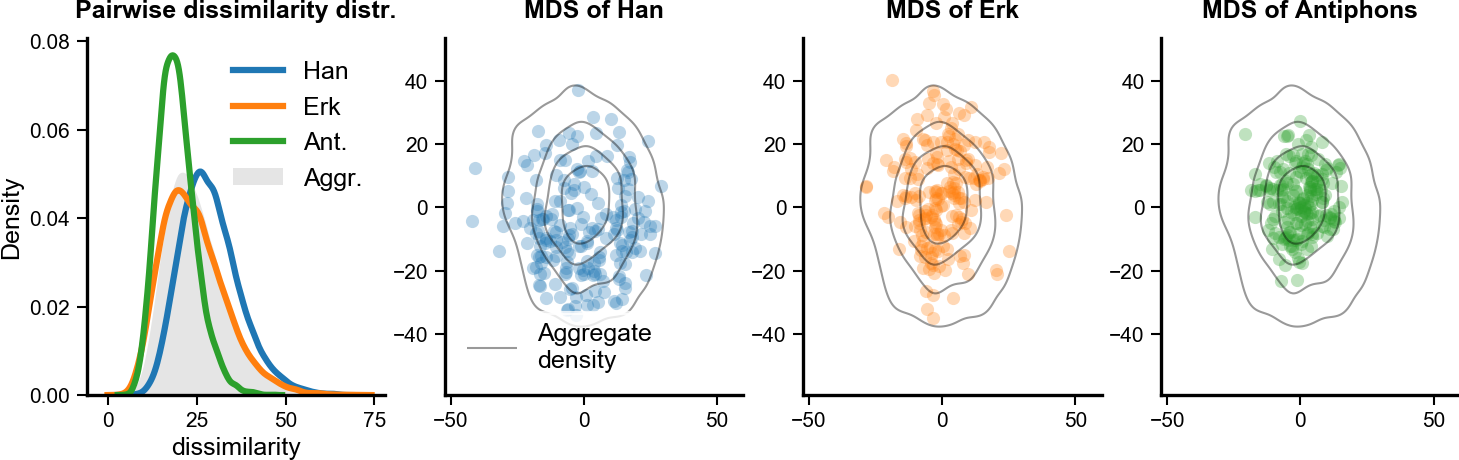

In [106]:
show_space(*load_data('centered', 200, 'eucl'))
plt.savefig('../figures/fig-dist-dip-centered-eucl.pdf')

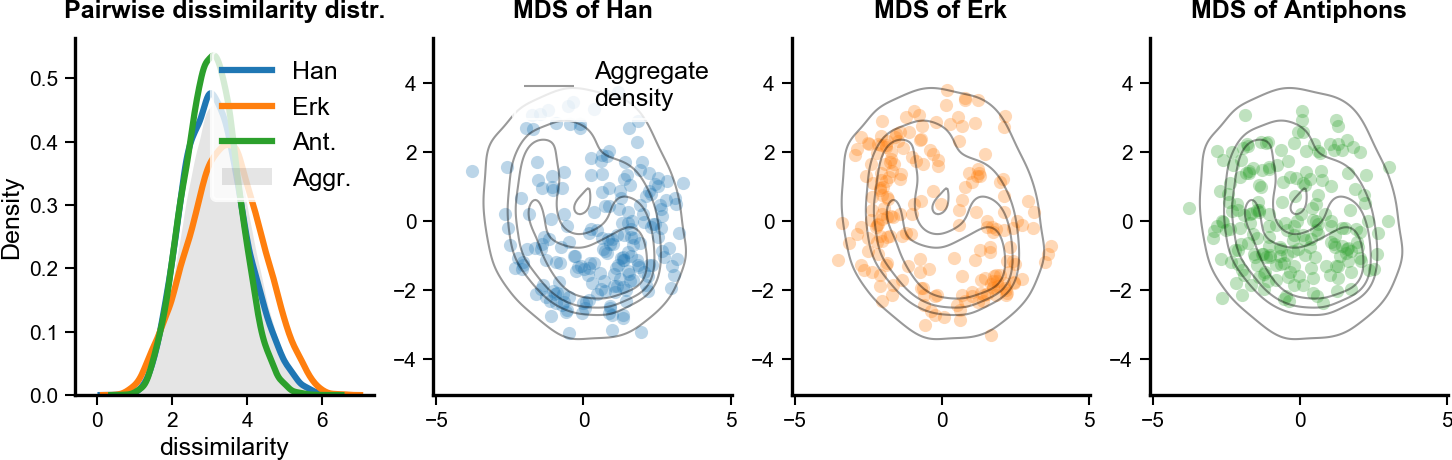

In [111]:
show_space(*load_data('normalized', 200, 'eucl'))
plt.savefig('../figures/fig-dist-dip-normalized-eucl.pdf')

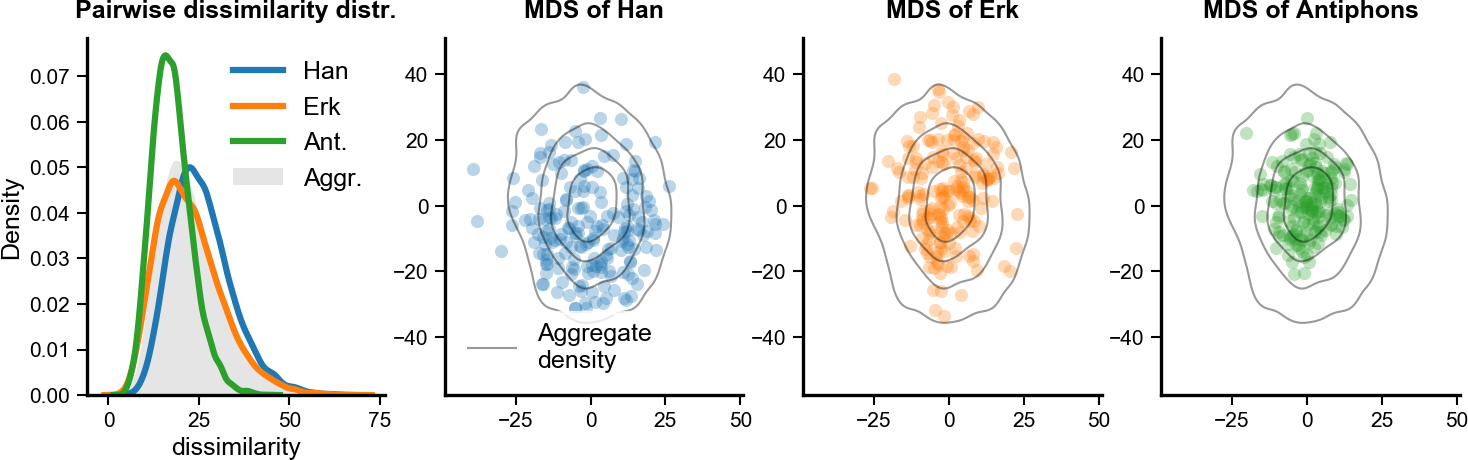

In [107]:
show_space(*load_data('smooth', 200, 'eucl'))
plt.savefig('../figures/fig-dist-dip-smooth-eucl.pdf')

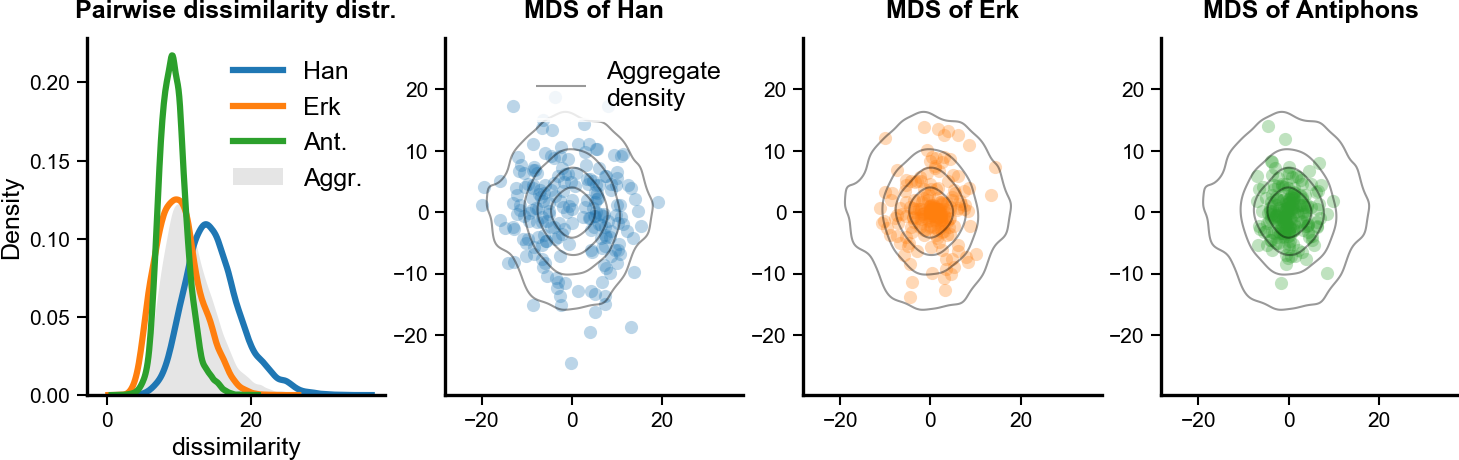

In [108]:
show_space(*load_data('intervals', 200, 'eucl'))
plt.savefig('../figures/fig-dist-dip-intervals-eucl.pdf')

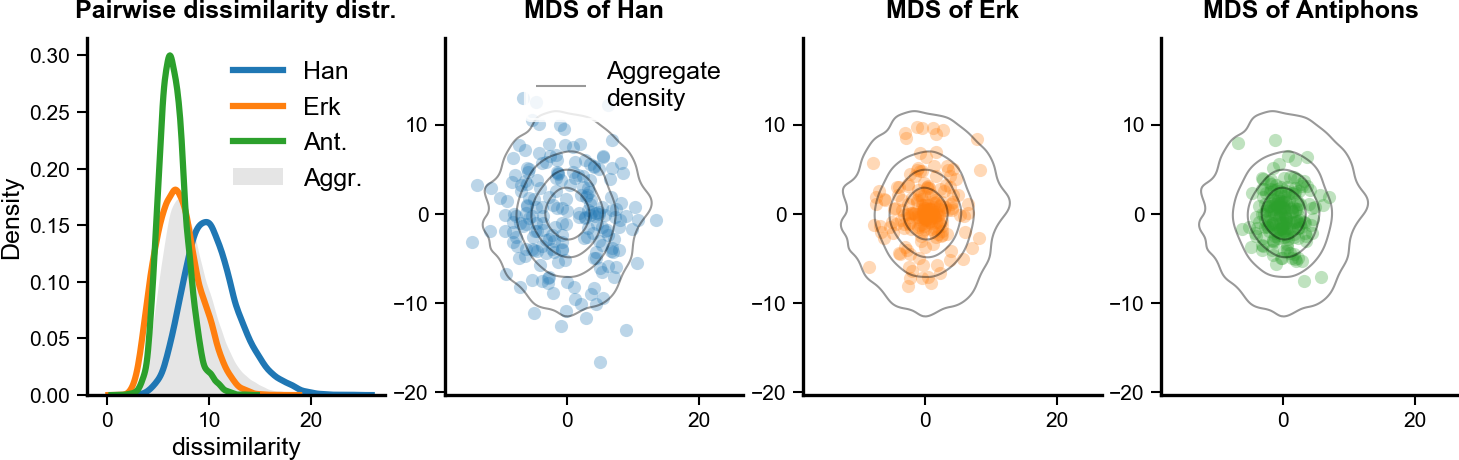

In [109]:
show_space(*load_data('derivatives', 200, 'eucl'))
plt.savefig('../figures/fig-dist-dip-derivatives-eucl.pdf')

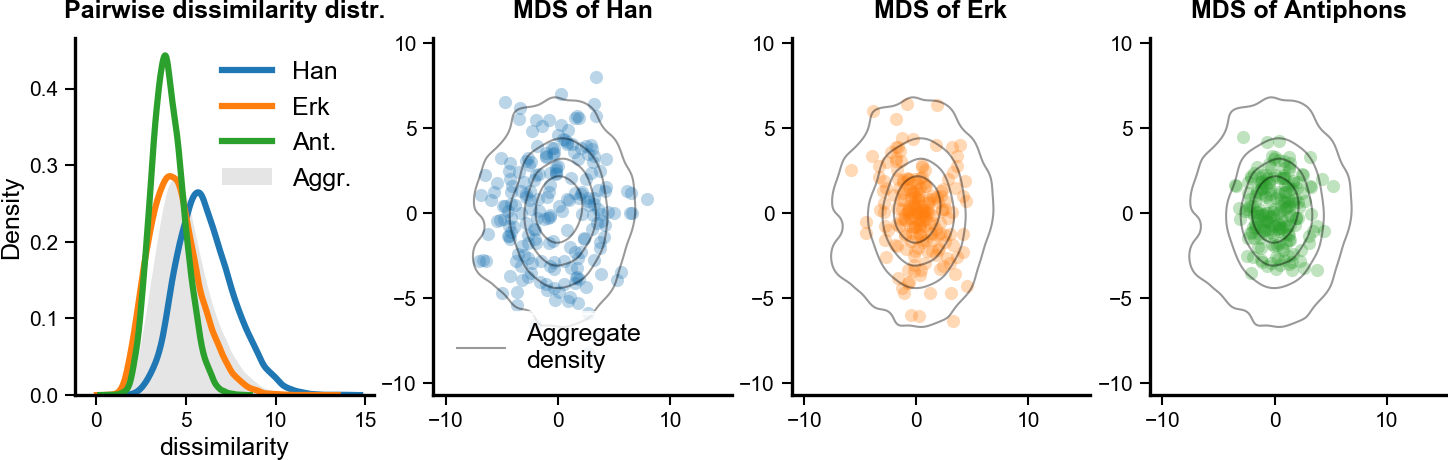

In [110]:
show_space(*load_data('smooth_derivatives', 200, 'eucl'))
plt.savefig('../figures/fig-dist-dip-smooth_derivatives-eucl.pdf')

## DTW

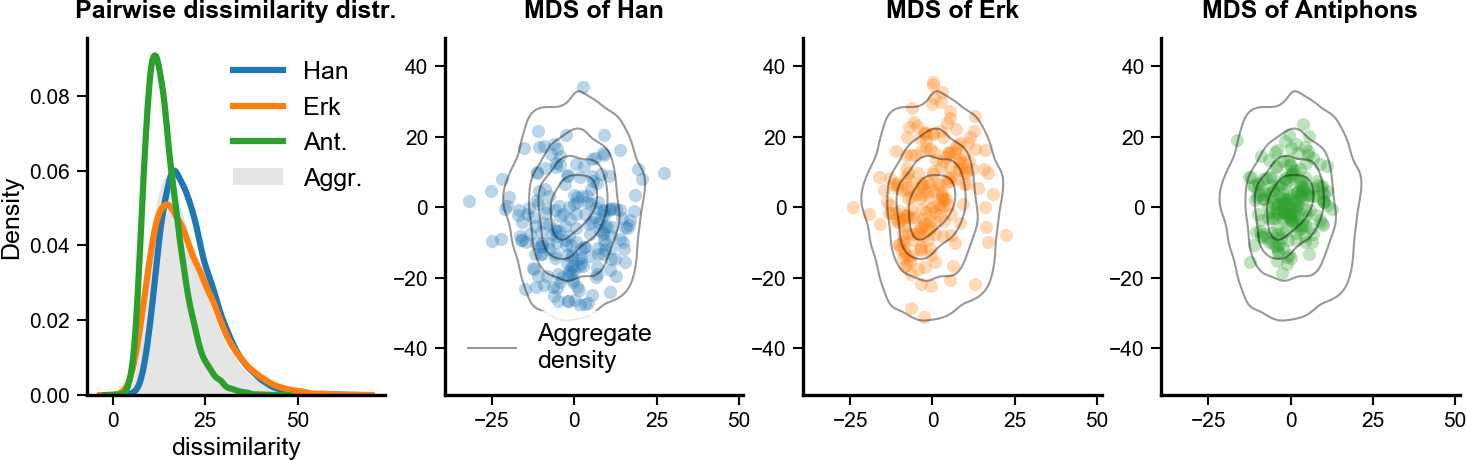

In [112]:
show_space(*load_data('centered', 200, 'dtw'))
plt.savefig('../figures/fig-dist-dip-centered-dtw.pdf')

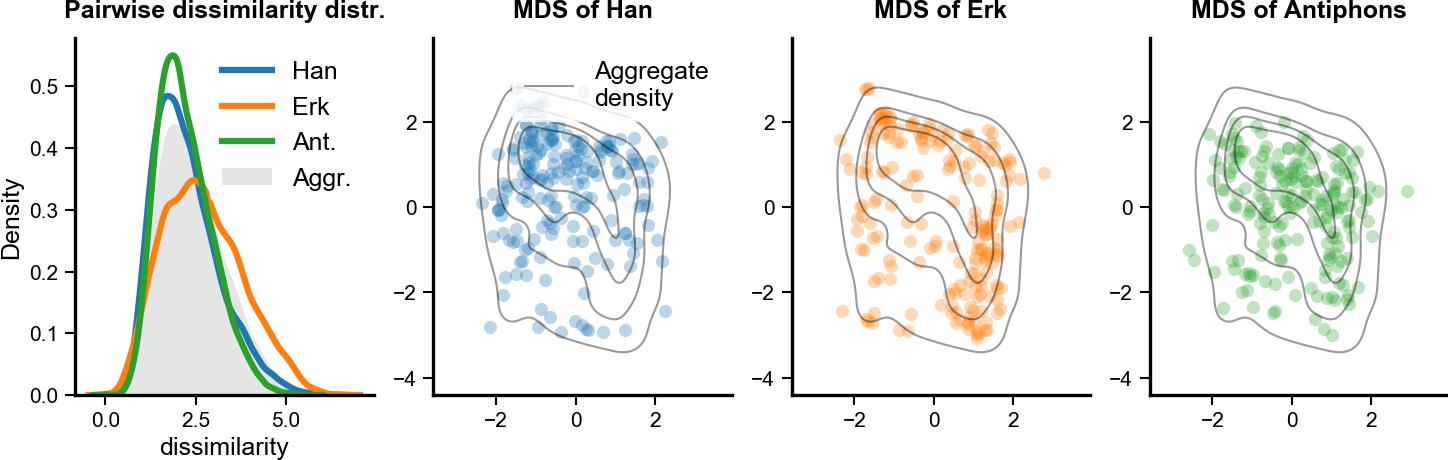

In [113]:
show_space(*load_data('normalized', 200, 'dtw'))
plt.savefig('../figures/fig-dist-dip-normalized-dtw.pdf')

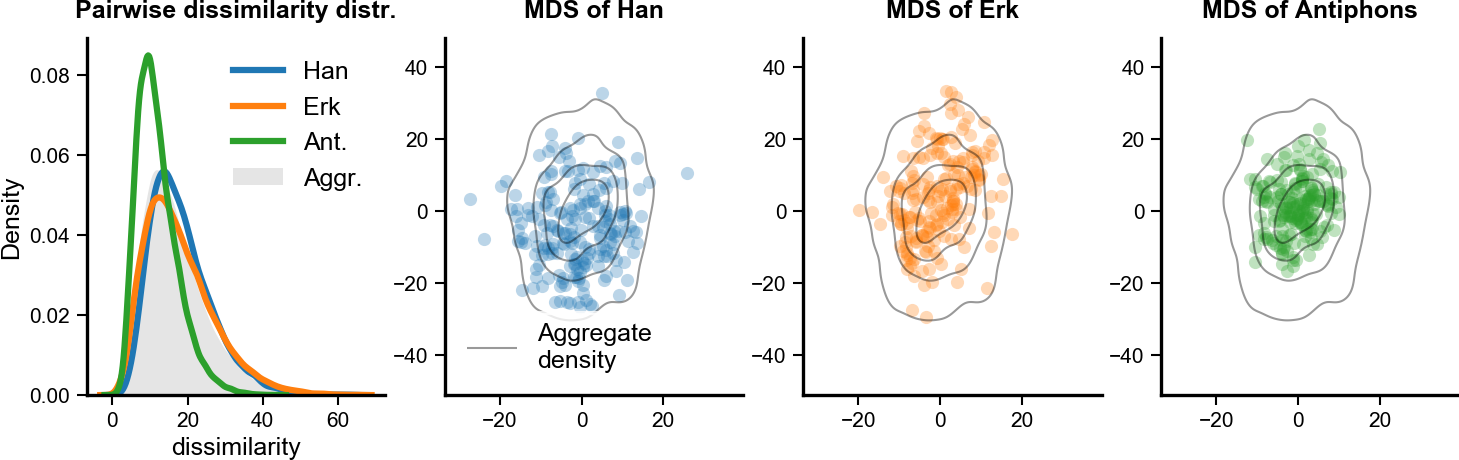

In [114]:
show_space(*load_data('smooth', 200, 'dtw'))
plt.savefig('../figures/fig-dist-dip-smooth-dtw.pdf')

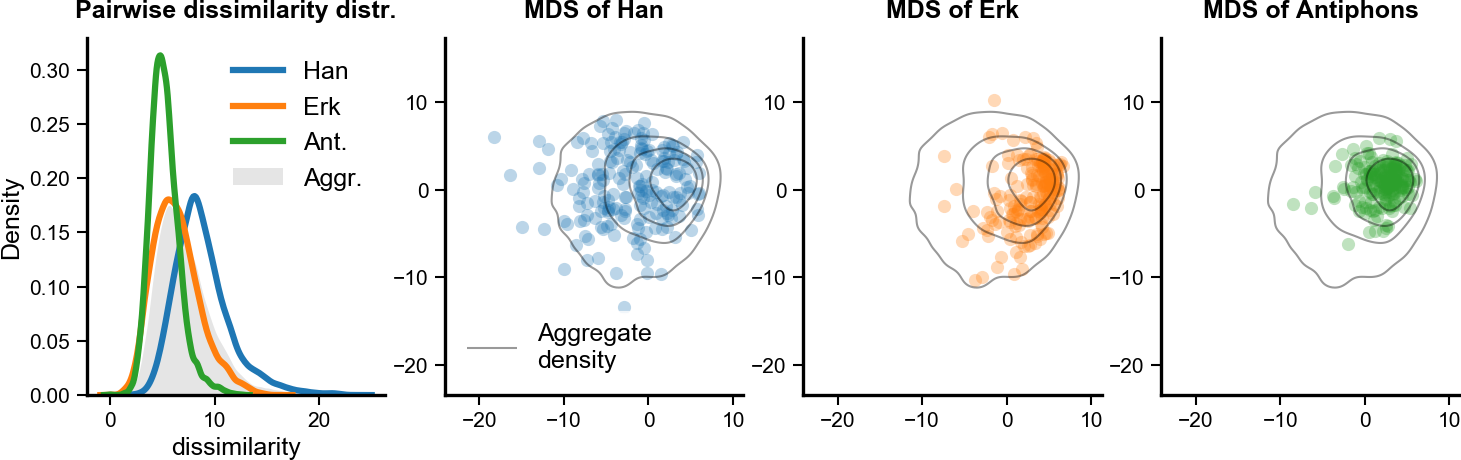

In [115]:
show_space(*load_data('intervals', 200, 'dtw'))
plt.savefig('../figures/fig-dist-dip-intervals-dtw.pdf')

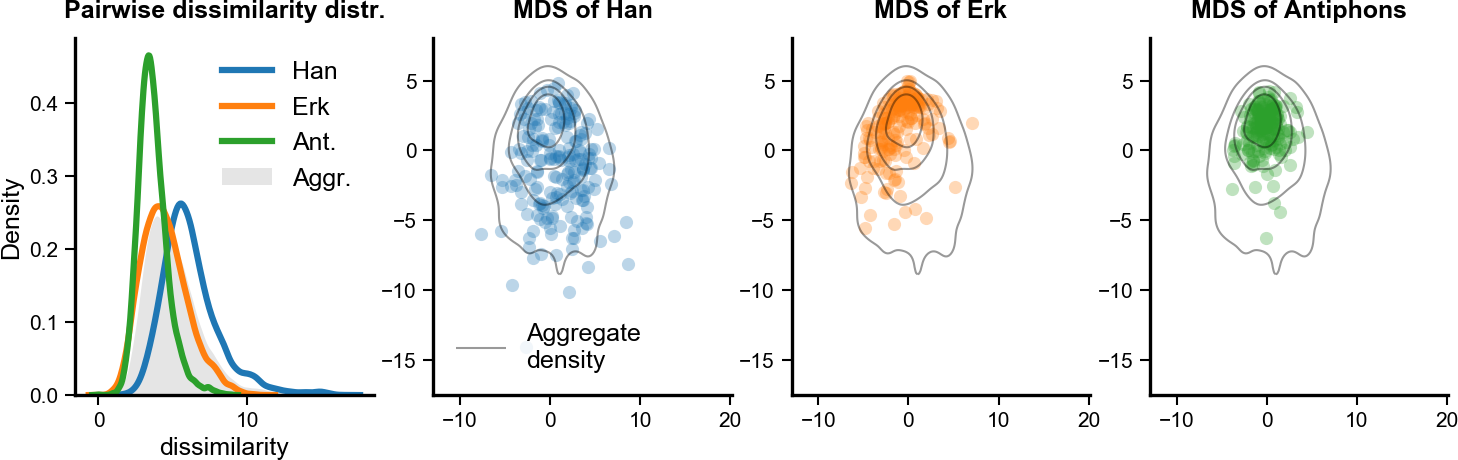

In [116]:
show_space(*load_data('derivatives', 200, 'dtw'))
plt.savefig('../figures/fig-dist-dip-derivatives-dtw.pdf')

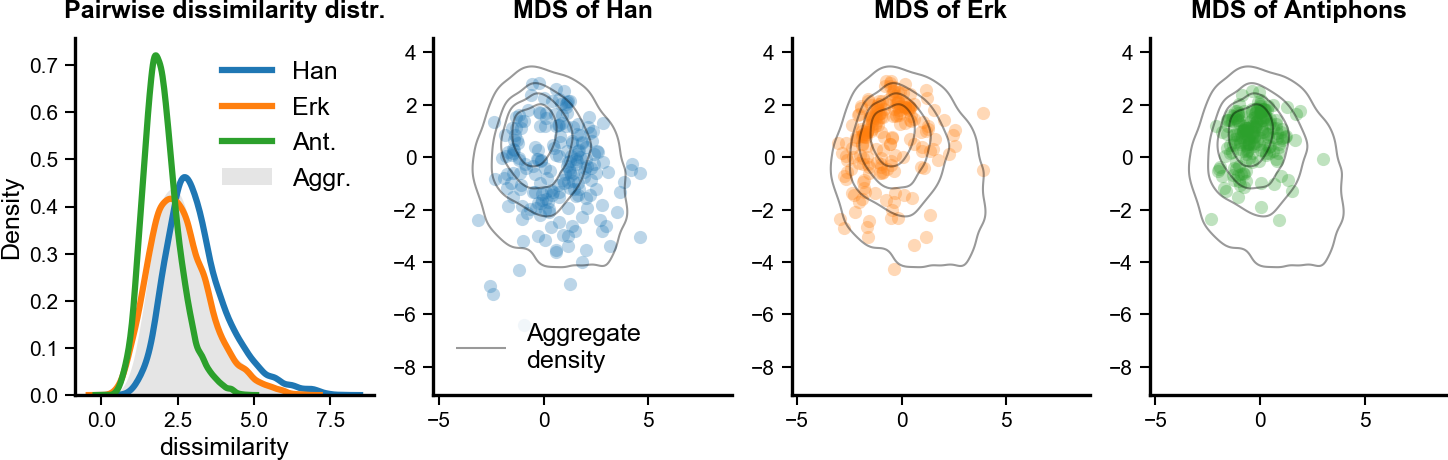

In [117]:
show_space(*load_data('smooth_derivatives', 200, 'dtw'))
plt.savefig('../figures/fig-dist-dip-smooth_derivatives-dtw.pdf')

# Double check

In [91]:
erk_df = pd.read_csv('../contours/erk-phrase-contours.csv', index_col=0)

In [93]:
contours = erk_df[[str(i) for i in range(50)]]

In [94]:
centered = contours - contours.mean(axis=1)[:, np.newaxis]

In [98]:
from scipy.spatial.distance import pdist

In [99]:
D = pdist(centered.sample(2000, random_state=0))

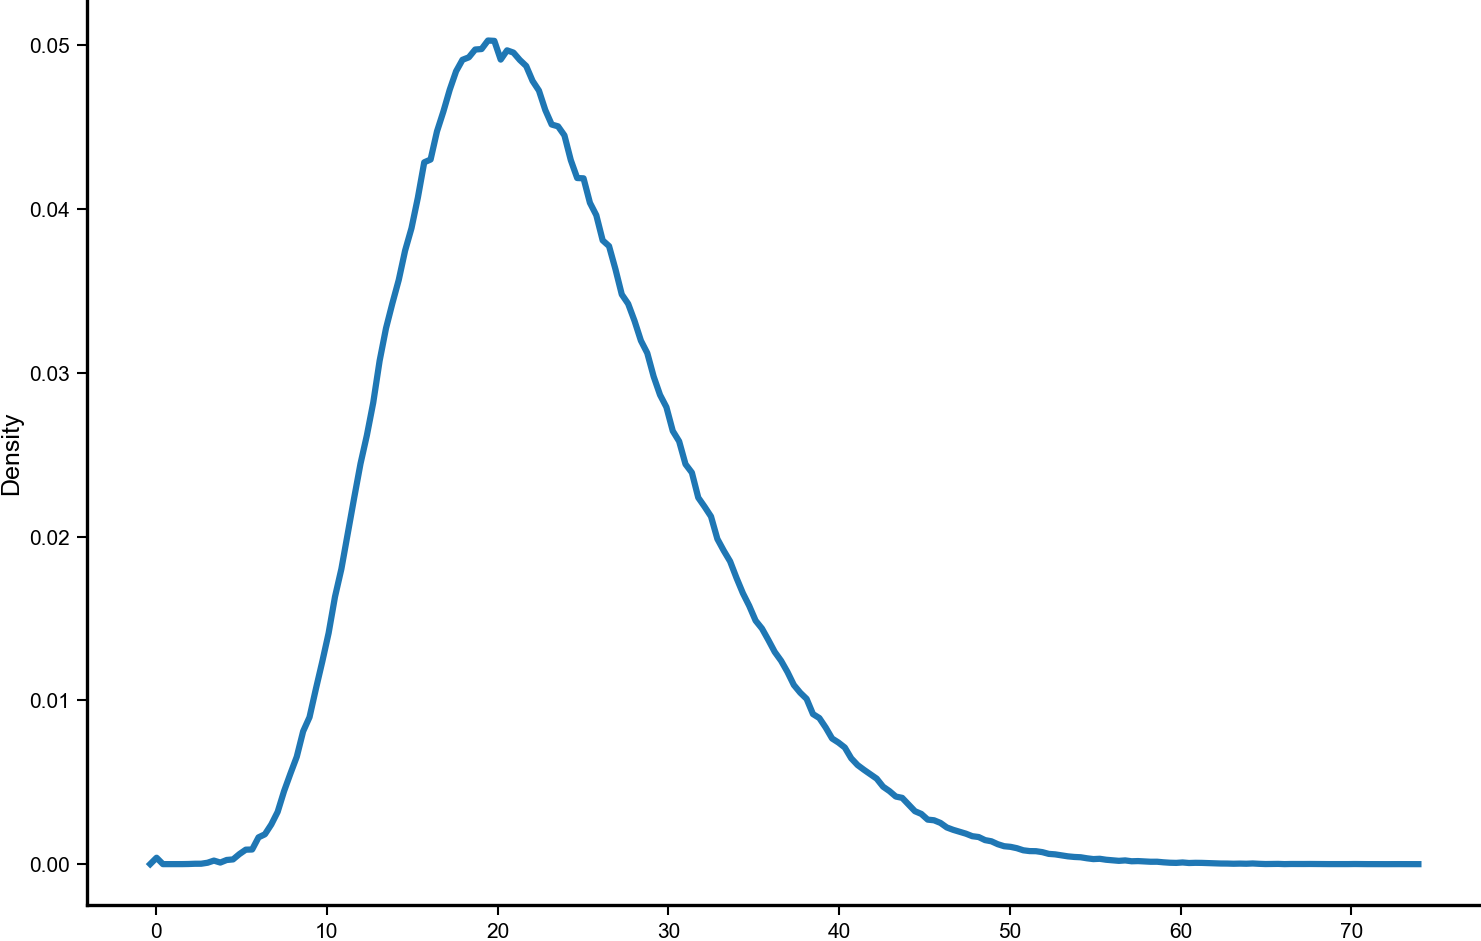

In [104]:
sns.kdeplot(D, bw_adjust=.25)

In [ ]:
def ylabel_matrix(text, y, pad=-5):
    plt.gca().annotate(text, xy=(0, y), xytext=(pad, 0),
                       xycoords='axes fraction', textcoords='offset points',
                       va='center', ha='right', rotation=90, fontsize='small')
    
def xlabel_matrix(text, x, pad=-5):
    plt.gca().annotate(text, xy=(x, 0), xytext=(0, pad),
                       xycoords='axes fraction', textcoords='offset points',
                       va='top', ha='center', fontsize='small')

def show_similarity_matrix(dm):
    plt.imshow(dm, cmap='Blues')
    plt.axvline(N, c='k', ls='--', lw=.5)
    plt.axvline(2*N, c='k', ls='--', lw=.5)
    plt.axhline(N, c='k', ls='--', lw=.5)
    plt.axhline(2*N, c='k', ls='--', lw=.5)
    plt.axis('off')
    ax = plt.gca()
    ylabel_matrix('Erk', 5/6)
    ylabel_matrix('Han', 1/2)
    ylabel_matrix('Gregorian', 1/6)
    xlabel_matrix('Erk', 1/6)
    xlabel_matrix('Han', 1/2)
    xlabel_matrix('Gregorian', 5/6)
    
# show_similarity_matrix(eucl_dm)